In [1]:
import numpy as np
import pandas as pd

from pathlib import Path
from typing import *

from sklearn.model_selection import train_test_split

import torch
import torch.optim as optim
from fastai import *
from fastai.vision import *
from fastai.text import *
from fastai.callbacks import *
from sklearn.model_selection import  train_test_split

package_dir_a = "../input/pytorch-pretrained-BERT/"
sys.path.insert(0, package_dir_a)


from pytorch_pretrained_bert import BertTokenizer
from pytorch_pretrained_bert.modeling import BertConfig, BertForSequenceClassification

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"  # specify which GPU(s) to be used


In [2]:
device=torch.device('cuda')
torch.cuda.device_count()
torch.cuda.get_device_name(0)
torch.cuda.get_device_properties(device).total_memory
torch.cuda.is_available()
torch.cuda.memory_allocated(device=None)
print('remaining cuda memory is: {}'.format(torch.cuda.get_device_properties(device).total_memory - torch.cuda.memory_allocated(device=None) ))


remaining cuda memory is: 16945512448


In [3]:
DATA_ROOT = '../input/'

class Config(dict):

    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        for k, v in kwargs.items():
            setattr(self, k, v)

    def set(self, key, val):
        self[key] = val
        setattr(self, key, val)


config = Config(
    testing=False,
    bert_model_name="bert-base-uncased",
    max_lr=2e-5,
    #epochs=3,
    epochs=2,
    use_fp16=True,
    bs=32,
    discriminative=False,
    max_seq_len=240,
)


bert_tok = BertTokenizer.from_pretrained('../input/bert-pretrained-models/uncased_L-12_H-768_A-12/'
)


def _join_texts(texts:Collection[str], mark_fields:bool=False, sos_token:Optional[str]=BOS):
    """Borrowed from fast.ai source"""
    if not isinstance(texts, np.ndarray): texts = np.array(texts)
    if is1d(texts): texts = texts[:,None]
    df = pd.DataFrame({i:texts[:,i] for i in range(texts.shape[1])})
    text_col = f'{FLD} {1}' + df[0].astype(str) if mark_fields else df[0].astype(str)
    if sos_token is not None: text_col = f"{sos_token} " + text_col
    for i in range(1,len(df.columns)):
        #text_col += (f' {FLD} {i+1} ' if mark_fields else ' ') + df[i]
        text_col += (f' {FLD} {i+1} ' if mark_fields else ' ') + df[i].astype(str)
    return text_col.values


class FastAiBertTokenizer(BaseTokenizer):

    """Wrapper around BertTokenizer to be compatible with fast.ai"""
    def __init__(self, tokenizer: BertTokenizer, max_seq_len: int=128, **kwargs):
        self._pretrained_tokenizer = tokenizer
        self.max_seq_len = max_seq_len

    def __call__(self, *args, **kwargs):
        return self

    def tokenizer(self, t:str) -> List[str]:
        """Limits the maximum sequence length"""
        return ["[CLS]"] + self._pretrained_tokenizer.tokenize(t)[:self.max_seq_len - 2] + ["[SEP]"]

identity_columns = [
    'male', 'female', 'homosexual_gay_or_lesbian', 'christian', 'jewish',
    'muslim', 'black', 'white', 'psychiatric_or_mental_illness']

train = pd.read_csv('../input/jigsaw-unintended-bias-in-toxicity-classification/train.csv')
train['comment_text'] = train['comment_text']
train = train.fillna(0)
train['target']=(train['target']>=0.5).astype(float)
weights = np.ones(len(train)) / 4
weights += (train[identity_columns].fillna(0).values >= 0.5).sum(axis=1).astype(bool).astype(np.int) / 4
weights += (( (train['target'].values >= 0.5).astype(bool).astype(np.int) +
   (train[identity_columns].fillna(0).values < 0.5).sum(axis=1).astype(bool).astype(np.int) ) > 1 ).astype(bool).astype(np.int) / 4
weights += (( (train['target'].values < 0.5).astype(bool).astype(np.int) +
   (train[identity_columns].fillna(0).values >= 0.5).sum(axis=1).astype(bool).astype(np.int) ) > 1 ).astype(bool).astype(np.int) / 4

train['weight'] = weights

train, val = train_test_split(train,test_size=0.05,shuffle=True, random_state=1024)

test = pd.read_csv('../input/jigsaw-unintended-bias-in-toxicity-classification/test.csv')


fastai_bert_vocab = Vocab(list(bert_tok.vocab.keys()))

fastai_tokenizer = Tokenizer(tok_func=FastAiBertTokenizer(bert_tok, max_seq_len=config.max_seq_len), pre_rules=[], post_rules=[])

label_cols = ['target', 'weight','severe_toxicity', 'obscene', 'identity_attack', 'insult', 'threat']


In [4]:
from pytorch_pretrained_bert import convert_tf_checkpoint_to_pytorch
from pytorch_pretrained_bert import BertTokenizer, BertForSequenceClassification,BertAdam
# Translate model from tensorflow to pytorch
WORK_DIR = "../working/"
BERT_MODEL_PATH = '../input/bert-pretrained-models/uncased_L-12_H-768_A-12/'
convert_tf_checkpoint_to_pytorch.convert_tf_checkpoint_to_pytorch(
    BERT_MODEL_PATH + 'bert_model.ckpt',
BERT_MODEL_PATH + 'bert_config.json',
WORK_DIR + 'pytorch_model.bin')

shutil.copyfile(BERT_MODEL_PATH + 'bert_config.json', WORK_DIR + 'bert_config.json')

/home/windywinter/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Building PyTorch model from configuration: {
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "max_position_embeddings": 512,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "type_vocab_size": 2,
  "vocab_size": 30522
}

Converting TensorFlow checkpoint from /home/windywinter/JigSaw/input/bert-pretrained-models/uncased_L-12_H-768_A-12/bert_model.ckpt
Loading TF weight bert/embeddings/LayerNorm/beta with shape [768]
Loading TF weight bert/embeddings/LayerNorm/gamma with shape [768]
Loading TF weight bert/embeddings/position_embeddings with shape [512, 768]
Loading TF weight bert/embeddings/token_type_embeddings with shape [2, 768]
Loading TF weight bert/embeddings/word_embeddings with shape [30522, 768]
Loading TF weight bert/encoder/layer_0/attention/output/LayerNorm/beta with shape [768]
Loading TF weight bert/encoder/layer_0/attention/output/LayerNor

Loading TF weight bert/encoder/layer_3/attention/self/value/kernel with shape [768, 768]
Loading TF weight bert/encoder/layer_3/intermediate/dense/bias with shape [3072]
Loading TF weight bert/encoder/layer_3/intermediate/dense/kernel with shape [768, 3072]
Loading TF weight bert/encoder/layer_3/output/LayerNorm/beta with shape [768]
Loading TF weight bert/encoder/layer_3/output/LayerNorm/gamma with shape [768]
Loading TF weight bert/encoder/layer_3/output/dense/bias with shape [768]
Loading TF weight bert/encoder/layer_3/output/dense/kernel with shape [3072, 768]
Loading TF weight bert/encoder/layer_4/attention/output/LayerNorm/beta with shape [768]
Loading TF weight bert/encoder/layer_4/attention/output/LayerNorm/gamma with shape [768]
Loading TF weight bert/encoder/layer_4/attention/output/dense/bias with shape [768]
Loading TF weight bert/encoder/layer_4/attention/output/dense/kernel with shape [768, 768]
Loading TF weight bert/encoder/layer_4/attention/self/key/bias with shape [76

Initialize PyTorch weight ['bert', 'encoder', 'layer_0', 'output', 'LayerNorm', 'gamma']
Initialize PyTorch weight ['bert', 'encoder', 'layer_0', 'output', 'dense', 'bias']
Initialize PyTorch weight ['bert', 'encoder', 'layer_0', 'output', 'dense', 'kernel']
Initialize PyTorch weight ['bert', 'encoder', 'layer_1', 'attention', 'output', 'LayerNorm', 'beta']
Initialize PyTorch weight ['bert', 'encoder', 'layer_1', 'attention', 'output', 'LayerNorm', 'gamma']
Initialize PyTorch weight ['bert', 'encoder', 'layer_1', 'attention', 'output', 'dense', 'bias']
Initialize PyTorch weight ['bert', 'encoder', 'layer_1', 'attention', 'output', 'dense', 'kernel']
Initialize PyTorch weight ['bert', 'encoder', 'layer_1', 'attention', 'self', 'key', 'bias']
Initialize PyTorch weight ['bert', 'encoder', 'layer_1', 'attention', 'self', 'key', 'kernel']
Initialize PyTorch weight ['bert', 'encoder', 'layer_1', 'attention', 'self', 'query', 'bias']
Initialize PyTorch weight ['bert', 'encoder', 'layer_1', 'a

'../working/bert_config.json'

In [5]:
print(train.shape)
print(val.shape)

(1714630, 46)
(90244, 46)


In [6]:
class BertTokenizeProcessor(TokenizeProcessor):

    def __init__(self, tokenizer):
        super().__init__(tokenizer=tokenizer, include_bos=False, include_eos=False)


class BertNumericalizeProcessor(NumericalizeProcessor):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, vocab=Vocab(list(bert_tok.vocab.keys())), **kwargs)


def get_bert_processor(tokenizer:Tokenizer=None, vocab:Vocab=None):
    """
    Constructing preprocessors for BERT
    We remove sos/eos tokens since we add that ourselves in the tokenizer.
    We also use a custom vocabulary to match the numericalization with the original BERT model.
    """
    return [BertTokenizeProcessor(tokenizer=tokenizer),
            NumericalizeProcessor(vocab=vocab)]


class BertDataBunch(TextDataBunch):

    @classmethod
    def from_df(cls, path:PathOrStr, train_df:DataFrame, valid_df:DataFrame, test_df:Optional[DataFrame]=None,
                tokenizer:Tokenizer=None, vocab:Vocab=None, classes:Collection[str]=None, text_cols:IntsOrStrs=1,
                label_cols:IntsOrStrs=0, label_delim:str=None, **kwargs) -> DataBunch:
        "Create a `TextDataBunch` from DataFrames."
        p_kwargs, kwargs = split_kwargs_by_func(kwargs, get_bert_processor)
        # use our custom processors while taking tokenizer and vocab as kwargs
        processor = get_bert_processor(tokenizer=tokenizer, vocab=vocab, **p_kwargs)
        if classes is None and is_listy(label_cols) and len(label_cols) > 1: classes = label_cols
        src = ItemLists(path, TextList.from_df(train_df, path, cols=text_cols, processor=processor),
                        TextList.from_df(valid_df, path, cols=text_cols, processor=processor))
        src = src.label_for_lm() if cls==TextLMDataBunch else src.label_from_df(cols=label_cols, classes=classes)
        if test_df is not None: src.add_test(TextList.from_df(test_df, path, cols=text_cols))
        return src.databunch(**kwargs)


# this will produce a virtually identical databunch to the code above
databunch = BertDataBunch.from_df(".", train, val, test,
                  tokenizer=fastai_tokenizer,
                  vocab=fastai_bert_vocab,
                  text_cols="comment_text",
                  label_cols=label_cols,
                  bs=config.bs,
                  collate_fn=partial(pad_collate, pad_first=False, pad_idx=0),
             )


bert_model =  BertForSequenceClassification.from_pretrained("../working/",cache_dir=None,num_labels=7)


# def custom_loss(data, targets):
#     ''' Define custom loss function for weighted BCE on 'target' column '''
#     bce_loss_1 = nn.BCEWithLogitsLoss(weight=targets[:,1:2])(data[:,:1],targets[:,:1])
#     bce_loss_2 = nn.BCEWithLogitsLoss()(data[:,1:],targets[:,2:])
#     return (bce_loss_1 * loss_weight) + bce_loss_2

def custom_loss(y_pred, y_true):
    bce_loss_1 = F.binary_cross_entropy_with_logits(y_pred[:,:1].reshape(-1), y_true[:,:1].reshape(-1), weight=y_true[:,1:2].reshape(-1))   
    N = y_true.shape[1]
    custom_loss = bce_loss_1
    for i in range(N-2):
        custom_loss += F.binary_cross_entropy_with_logits(y_pred[:,1+i], y_true[:,2+i])
    return custom_loss


learner = Learner(databunch, bert_model, loss_func=custom_loss)


learner.fit_one_cycle(config.epochs, max_lr=config.max_lr)


#torch.save(learner.model,'./jin_fastai_bert_0.95_3_epoch.model')                # 6 label_cols
torch.save(learner.model, 'jin_files/jin_fastai_bert_0.95_2_epoch_1.model')      # 7 label_cols, weights added



epoch,train_loss,valid_loss,time
0,0.420887,0.422480,3:25:50
1,0.411872,0.417182,3:46:55


In [8]:
! cd models/ && ls

tmp.pth


In [10]:
learner.save('jin_models', 
             #return_path=True
            )


In [11]:
#learner.recorder.plot()


In [12]:
print('remaining cuda memory is: {}'.format(torch.cuda.get_device_properties(device).total_memory - torch.cuda.memory_allocated(device=None) ))


remaining cuda memory is: 15188444160


In [13]:
from tqdm import tqdm, tqdm_notebook

#model = torch.load("./jin_fastai_bert_0.95_3_epoch.model")
model = torch.load("jin_files/jin_fastai_bert_0.95_2_epoch_1.model")

model.to(device)
for param in model.parameters():
    param.requires_grad = False
model.eval()

MAX_SEQUENCE_LENGTH = 240

tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_PATH, cache_dir=None,do_lower_case=True)

def convert_lines(example, max_seq_length,tokenizer):
    max_seq_length -=2
    all_tokens = []
    longer = 0
    for text in tqdm_notebook(example):
        tokens_a = tokenizer.tokenize(text)
        if len(tokens_a)>max_seq_length:
            tokens_a = tokens_a[:max_seq_length]
            longer += 1
        one_token = tokenizer.convert_tokens_to_ids(["[CLS]"]+tokens_a+["[SEP]"])+[0] * (max_seq_length - len(tokens_a))
        all_tokens.append(one_token)
    print(longer)
    return np.array(all_tokens)

X_val = convert_lines(val["comment_text"].fillna("DUMMY_VALUE"), MAX_SEQUENCE_LENGTH,tokenizer)


valid = torch.utils.data.TensorDataset(torch.tensor(X_val,dtype=torch.long))
valid_loader = torch.utils.data.DataLoader(valid, batch_size=32, shuffle=False)
val_preds = np.zeros((len(val)))

tk0 = tqdm_notebook(valid_loader)
for i, (x_batch,) in enumerate(tk0):
    pred = model(x_batch.to(device), attention_mask=(x_batch>0).to(device), labels=None)
    val_preds[i*32:(i+1)*32]=pred[:,0].detach().cpu().squeeze().numpy()
    



A Jupyter Widget


467


A Jupyter Widget

In [14]:
def calculate_overall_auc(df, model_name):
    true_labels = df[TOXICITY_COLUMN]>0.5
    predicted_labels = df[model_name]
    return metrics.roc_auc_score(true_labels, predicted_labels)

def power_mean(series, p):
    total = sum(np.power(series, p))
    return np.power(total / len(series), 1 / p)

def get_final_metric(bias_df, overall_auc, POWER=-5, OVERALL_MODEL_WEIGHT=0.25):
    bias_score = np.average([
        power_mean(bias_df[SUBGROUP_AUC], POWER),
        power_mean(bias_df[BPSN_AUC], POWER),
        power_mean(bias_df[BNSP_AUC], POWER)
    ])
    return (OVERALL_MODEL_WEIGHT * overall_auc) + ((1 - OVERALL_MODEL_WEIGHT) * bias_score)


SUBGROUP_AUC = 'subgroup_auc'
BPSN_AUC = 'bpsn_auc'  # stands for background positive, subgroup negative
BNSP_AUC = 'bnsp_auc'  # stands for background negative, subgroup positive

def compute_auc(y_true, y_pred):
    try:
        return metrics.roc_auc_score(y_true, y_pred)
    except ValueError:
        return np.nan

def compute_subgroup_auc(df, subgroup, label, model_name):
    subgroup_examples = df[df[subgroup]>0.5]
    return compute_auc((subgroup_examples[label]>0.5), subgroup_examples[model_name])

def compute_bpsn_auc(df, subgroup, label, model_name):
    """Computes the AUC of the within-subgroup negative examples and the background positive examples."""
    subgroup_negative_examples = df[(df[subgroup]>0.5) & (df[label]<=0.5)]
    non_subgroup_positive_examples = df[(df[subgroup]<=0.5) & (df[label]>0.5)]
    examples = subgroup_negative_examples.append(non_subgroup_positive_examples)
    return compute_auc(examples[label]>0.5, examples[model_name])

def compute_bnsp_auc(df, subgroup, label, model_name):
    """Computes the AUC of the within-subgroup positive examples and the background negative examples."""
    subgroup_positive_examples = df[(df[subgroup]>0.5) & (df[label]>0.5)]
    non_subgroup_negative_examples = df[(df[subgroup]<=0.5) & (df[label]<=0.5)]
    examples = subgroup_positive_examples.append(non_subgroup_negative_examples)
    return compute_auc(examples[label]>0.5, examples[model_name])

def compute_bias_metrics_for_model(dataset,
                                   subgroups,
                                   model,
                                   label_col,
                                   include_asegs=False):
    """Computes per-subgroup metrics for all subgroups and one model."""
    records = []
    for subgroup in subgroups:
        record = {
            'subgroup': subgroup,
            'subgroup_size': len(dataset[dataset[subgroup]>0.5])
        }
        record[SUBGROUP_AUC] = compute_subgroup_auc(dataset, subgroup, label_col, model)
        record[BPSN_AUC] = compute_bpsn_auc(dataset, subgroup, label_col, model)
        record[BNSP_AUC] = compute_bnsp_auc(dataset, subgroup, label_col, model)
        records.append(record)
    return pd.DataFrame(records).sort_values('subgroup_auc', ascending=True)


In [15]:
from sklearn import metrics
identity_columns = [
    'male', 'female', 'homosexual_gay_or_lesbian', 'christian', 'jewish',
    'muslim', 'black', 'white', 'psychiatric_or_mental_illness']

MODEL_NAME = 'model1'
val[MODEL_NAME]=torch.sigmoid(torch.tensor(val_preds)).numpy()
TOXICITY_COLUMN = 'target'
bias_metrics_df = compute_bias_metrics_for_model(val, identity_columns, MODEL_NAME, 'target')
bias_metrics_df
print(get_final_metric(bias_metrics_df, calculate_overall_auc(val, MODEL_NAME)))


0.9373936883012964


In [16]:
bias_metrics_df

,bnsp_auc,bpsn_auc,subgroup,subgroup_auc,subgroup_size
2,0.957838,0.900081,homosexual_gay_or_lesbian,0.842071,514
6,0.966694,0.879365,black,0.843132,662
7,0.968096,0.901755,white,0.880164,1159
4,0.945955,0.946390,jewish,0.889125,323
5,0.964857,0.917054,muslim,0.892189,922
1,0.953538,0.957976,female,0.924232,2487
0,0.959916,0.954136,male,0.931169,1887
3,0.945862,0.965777,christian,0.931238,1742
8,0.967477,0.943249,psychiatric_or_mental_illness,0.935185,213


In [31]:
learner.lr_find(num_it=53582)


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


In [29]:
#?learner.lr_find()

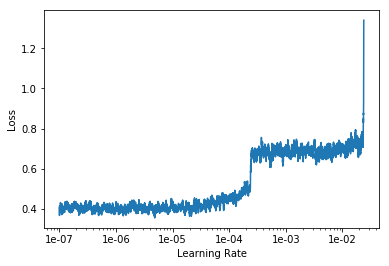

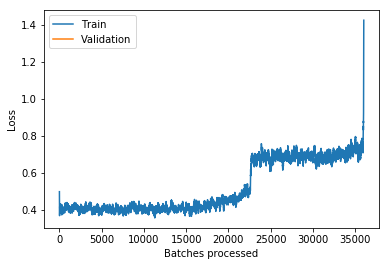

In [32]:
%matplotlib inline
learner.recorder.plot()
learner.recorder.plot_losses()


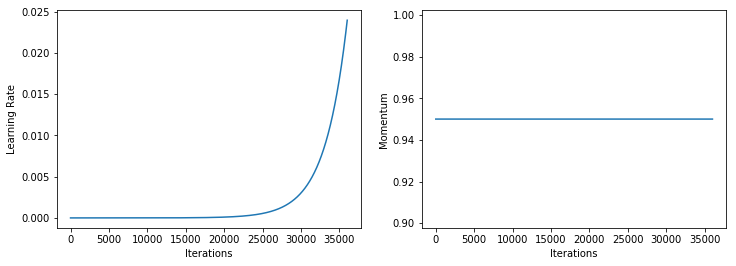

In [33]:
learner.recorder.plot_lr(show_moms=True)